In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

In [ ]:
#Used chatgpt for reference

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/AutoEncoder for images/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

# Build an Autoencoder for a human face dataset

### We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

### Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


#`PyTorch DataLoader and Transformation Setup`

---

1. `Defining Transformations`:
The line transform = transforms.Compose([transforms.ToTensor()]) initializes a transformation pipeline. transforms.Compose is used to chain together multiple image transformations. In this case, there is only one transformation - transforms.ToTensor(), which converts PIL images or NumPy arrays into PyTorch tensors, normalizing the pixel values to the range [0.0, 1.0].

2. `Initializing the DataLoader`:
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True) creates a DataLoader object for iterating over the dataset.

 1. `ImageFolder Dataset`: ImageFolder(path, transform,) loads images from the specified path, where each subdirectory contains images of a specific class. The transform is applied to each image.

  2. `Batch Size`: batch_size=32 configures the DataLoader to provide batches of 32 images at a time. This is crucial for batch processing in model training.

   3. `Shuffling`: shuffle=True indicates that the dataset should be shuffled at the beginning of each epoch, promoting model generalization by reducing order bias.


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("cuda")
else:
    print ("CUDA device not found.")


CUDA device not found.


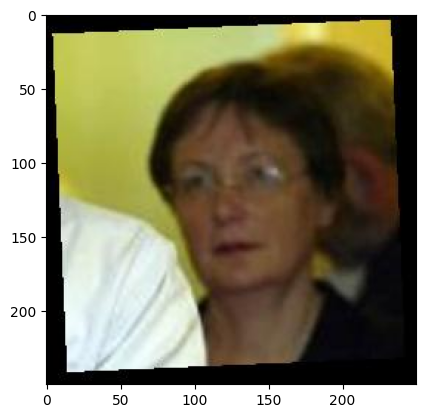

In [7]:
import matplotlib.pyplot as plt

# Iterate over the DataLoader
for x, _ in dataloader:
    # Select the first image from the batch and permute the dimensions from (C, H, W) to (H, W, C)
    image_to_show = x[0].permute(1, 2, 0)

    # Convert the image from PyTorch tensor to numpy array
    image_to_show = image_to_show.numpy()
    if image_to_show.max() <= 1:
        image_to_show = (image_to_show * 255).astype('uint8')

    # Display the image
    plt.imshow(image_to_show)
    plt.show()
    break  # Stop after the first batch


#`Visualizing Images from DataLoader`#

---



1. **`Iterating Over the DataLoader:`**
This loops through the batches in the DataLoader. Each batch contains a set of images and their corresponding labels (or targets).

2. **`Selecting the First Image:`**
The code x[0] selects the first image in the batch. In PyTorch, images in a batch are typically stacked along the first dimension.

3. **`Permuting Dimensions:`**
The .permute(1, 2, 0) method changes the order of the dimensions of the image from (C, H, W) (Channels, Height, Width) to (H, W, C) (Height, Width, Channels). This is the format expected by matplotlib for RGB images.

4. **`onverting to Numpy Array:`**
Matplotlib expects a numpy array for image visualization. The tensor is converted to a numpy array using .numpy().

5. **`Rescaling:`**
If the image tensor is normalized (values between 0 and 1), it's rescaled to a range of 0 to 255 and converted to uint8 for proper visualization. This step is necessary for displaying the image correctly.

6. **`Displaying the Image:`**
plt.imshow(image_to_show) is used to display the image. Here, image_to_show is the image after performing the above steps.

7. **`Breaking After the First Batch:`**The break statement ensures that the loop
 exits after processing the first batch, hence displaying only the first image of the first batch.

## Step 2

### Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
# Using next() to obtain the first batch from the DataLoader
first_batch = next(iter(dataloader))
sample_image = first_batch[0][15]  # Selecting one image from the batch

# Displaying the dimensions of the chosen image
image_dims = sample_image.shape
print(f"Shape of the selected image: {image_dims}")

# Explaining the meaning of each dimension
channel, height, width = image_dims
print(f"\nDimension Details:")
print(f"- Number Of Channels: {channel}")
print(f"- Height: {height} pixels")
print(f"- Width: {width} pixels")


Shape of the selected image: torch.Size([3, 250, 250])

Dimension Details:
- Number Of Channels: 3
- Height: 250 pixels
- Width: 250 pixels


#Dimension and Shape explaination

---


1. `Shape of the Selected Image:`
torch.Size([3, 250, 250])
This output indicates that the image is represented as a tensor with the shape of 3 channels, each 250 pixels in height and 250 pixels in width.
In PyTorch, torch.Size([...]) is a tuple describing the dimensions of a tensor.
2. `Dimension Details:`
Channels: 3 (Typically 3 for RGB images)
The first dimension 3 represents the number of color channels. In RGB images, there are three channels representing red, green, and blue.
Height: 250 pixels
The second dimension 250 denotes the height of the image in pixels.
Width: 250 pixels
The third dimension 250 represents the width of the image in pixels.

# Step 3

### Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)  # Output: [64, 125, 125]
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Output: [64, 62, 62]
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output: [128, 31, 31]
        self.enc_bn2 = nn.BatchNorm2d(128)

        # Decoder Layers
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Output: [64, 62, 62]
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: [32, 124, 124]
        self.dec_bn2 = nn.BatchNorm2d(32)
        # Adjusted kernel size and padding to match the output size
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=0)  # Output: [3, 250, 250]
        self.dec_bn3 = nn.BatchNorm2d(3)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        return x

    def decoder(self, x):
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = self.dec_conv3(x)
        x = self.dec_bn3(x)
        x = torch.sigmoid(x)  # Normalize the output
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




#`In-Depth Explanation of Autoencoder (AE) Model`

---


1. **`Class Definition and Inheritance:`**
* `class AE(nn.Module)`: defines a new class AE, which is an
Autoencoder. It inherits from nn.Module, a base class for all neural network modules in PyTorch. This inheritance is crucial for leveraging built-in functionalities of PyTorch like backpropagation, parameter management, etc.
2. **`Constructor and Super Function:`**

* `def __init__(self)`: is the constructor of the class. It defines the structure of the neural network.
super(AE, self).__init__() calls the constructor of the parent class (nn.Module). This is necessary to properly initialize the model.
3. **`Encoder Layers:`**

* `First Convolutional Layer (enc_conv1)`:
nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1) creates a 2D convolutional layer.
It takes 3 input channels (RGB image), outputs 64 feature maps, has a kernel size of 4x4, a stride of 2, and a padding of 1. The stride reduces the spatial dimensions by half, and padding adds zeros around the input for boundary pixels.
* `Batch Normalization (enc_bn1)`:
nn.BatchNorm2d(64) normalizes the output of the previous layer. It stabilizes the learning process and reduces the internal covariate shift.
* `Average Pooling Layer (enc_avgpool1)`:
nn.AvgPool2d(kernel_size=2, stride=2) applies average pooling with a 2x2 kernel and a stride of 2, reducing the spatial dimensions by half again.
* `Second Convolutional Layer (enc_conv2)`:
Similar to enc_conv1, but it takes 64 input feature maps (from enc_conv1) and outputs 128 feature maps.
4. **`Decoder Layers:`**

* `First Transposed Convolutional Layer (dec_conv1)`:
nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) is a transposed convolutional layer (sometimes called deconvolution). It upsamples the feature maps from 128 to 64 with a kernel size of 4, stride of 2, and padding of 1.
* `Second Transposed Convolutional Layer (dec_conv2)`:
Upsamples the feature maps further from 64 to 32.
Third Transposed Convolutional Layer (dec_conv3):
The final transposed convolutional layer upsamples the feature maps from 32 to 3, which matches the input channels, and adjusts the spatial dimensions to match the original input size.
5. **`Encoder Function:`**

* `def encoder(self, x):` defines the forward pass of the encoder. It applies each layer to the input x sequentially and uses the ReLU activation function (implemented as F.relu) for non-linearity.
6. **`Decoder Function:`**

* `def decoder(self, x)`: defines the forward pass of the decoder. Similar to the encoder, it applies layers sequentially. The final output is passed through a sigmoid function (torch.sigmoid) to normalize it between 0 and 1, which is typical for image reconstruction tasks.
7. **`Forward Function:`**

* `def forward(self, x):` defines the overall forward pass of the AE model. It sequentially calls the encoder and decoder on the input x. This method is automatically called during training and inference.

## Step 4

### Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In this part of our notebook, we initialize the custom autoencoder model `AE`, generate a test input, and pass it through the model. This process helps in verifying the functionality of the autoencoder's encoder and decoder, ensuring that the dimensions of the latent space and reconstructed output align with our expectations.

In [10]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# Initialize model, transform, and load image
brain = AE().cuda() if torch.cuda.is_available() else AE()
transform = transforms.Compose([transforms.Resize((250, 250)), transforms.ToTensor()])
image = transform(Image.open('/content/lfw/AJ_Lamas/AJ_Lamas_0001.jpg').convert('RGB')).unsqueeze(0)
image = image.cuda() if torch.cuda.is_available() else image

# Perform inference
with torch.no_grad():
    encoded = brain.encoder(image)
    decoded = brain.decoder(encoded)

# Print dimensions
print(f"Encoded: {encoded.shape}, Decoded: {decoded.shape}")

Encoded: torch.Size([1, 128, 31, 31]), Decoded: torch.Size([1, 3, 250, 250])



`Detailed Explanation of Autoencoder Inference Output`

1. **`Autoencoder Class Definition:`**

The AE class, defined as a subclass of torch.nn.Module, encapsulates the architecture of the Autoencoder. It includes an encoder for compressing the input image into a latent representation and a decoder for reconstructing the image from this representation.
2. **`Model Initialization and GPU Check:`**

The brain model is instantiated from the AE class. It's moved to the GPU for faster processing if CUDA is available.
3. **`Image Transformation Setup:`**

The transformation pipeline resizes the input image to 250x250 pixels and converts it into a PyTorch tensor, suitable for model processing.
4. **`Image Loading and Processing:`**

An image is loaded, converted to RGB, transformed, and a batch dimension is added to create a 4D tensor with shape [1, 3, 250, 250] (batch size, channels, height, width).
5. **`Performing Inference:`**

Inference is run without gradient calculations to save memory and computation time. The image tensor is passed through the encoder and decoder of the model.
6. **`Output Dimension Printing:`**

The dimensions of the encoded and decoded tensors are printed, showing the size of the latent space representation and the reconstructed image.
7. **`Analysis of Output Dimensions:`**

`Encoded Output`: torch.Size([1, 128, 31, 31])
This is the latent representation of the input image. The first dimension 1 indicates the batch size.
The second dimension 128 suggests the number of feature maps or channels in the latent space, which is determined by the architecture of the encoder's last layer in the AE model.

The dimensions 31x31 represent the spatial size of the feature maps. This size results from the downsampling operations (like convolutions and pooling) in the encoder.

`Decoded Output`: torch.Size([1, 3, 250, 250])
This is the reconstructed image. The first dimension 1 is again the batch size.

The 3 indicates the reconstructed image has 3 color channels, which matches the input image's channels.
The 250x250 dimensions confirm that the decoder has successfully upscaled the latent representation back to the original input size.

##  Step 5
### Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In this section, we prepare our autoencoder model `AE` for training. This involves calculating the total number of trainable parameters in the model, defining the loss function, and setting up the optimizer.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

brain = AE()

# Count the number of trainable parameters in the model
total_trainable_params = sum(p.numel() for p in brain.parameters() if p.requires_grad)
print(f"Trainable parameters in the autoencoder: {total_trainable_params}")

# Define the loss function as Mean Squared Error
criterion = nn.MSELoss()

# Set up the optimizer using the Adam algorithm
optimizer = optim.Adam(brain.parameters(), lr=0.001)


Trainable parameters in the autoencoder: 300393



`Detailed Analysis of Autoencoder Model Setup`
1. `Autoencoder Class Definition:`

The AE class, defined as a subclass of torch.nn.Module, encapsulates the Autoencoder's architecture. It typically includes layers for encoding and decoding, such as convolutional layers, pooling layers, and fully connected layers.
2. `Model Initialization:`

The line autoencoder = AE() creates an instance of the AE model. This instantiation initializes all the layers defined in the AE class.
3. `Counting Trainable Parameters:`

The expression sum(p.numel() for p in autoencoder.parameters() if p.requires_grad) calculates the total number of trainable parameters in the model.
autoencoder.parameters() returns an iterator over all parameters (weights and biases) of the model.
p.numel() returns the total number of elements in the parameter tensor p (which can be weights or biases for a layer).
if p.requires_grad ensures that only parameters that require gradients (i.e., trainable parameters) are included in the count.
The output Trainable parameters in the autoencoder: 300393 indicates that the autoencoder model has 300,393 parameters that will be updated during training.
4. `Setting Up the Loss Function:`

criterion = nn.MSELoss() sets up the Mean Squared Error Loss as the criterion for training the autoencoder. This loss function is commonly used for reconstruction tasks, where the goal is to minimize the difference between the original input and its reconstruction.
5. `Configuring the Optimizer:`

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001) initializes an Adam optimizer for the model.
This optimizer will update the model's parameters based on the computed gradients and is configured with a learning rate of 0.001.
Adam is a popular choice for training neural networks due to its efficiency and adaptive learning rate properties.



`Calculations Behind the Parameter Count:`

`Convolutional Layers:` Each convolutional layer has parameters based on the formula (in_channels * kernel_size * kernel_size + 1) * out_channels where +1 is for the bias. If there are multiple convolutional layers, their parameters are summed up.

`Fully Connected Layers:` Each fully connected (linear) layer has parameters calculated by (input_features + 1) * output_features, where +1 accounts for the bias term.

`Other Layers:` Other layers like pooling layers or batch normalization layers might also have parameters, depending on their specific configuration.

The total of 300,393 trainable parameters suggests a moderately complex model, capable of learning detailed features and patterns in the data, suitable for tasks like image reconstruction in autoencoders.

##  Step 6
### Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

We have set up a training loop for our autoencoder `AE` model. This loop runs through the dataset for a specified number of epochs, performing forward and backward passes, and optimizing the model parameters. After each epoch, the average loss is calculated and reported.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create an instance of the Autoencoder model
brain = AE()

# Check if CUDA (GPU support) is available and move the model to GPU if it is
if torch.cuda.is_available():
    brain.cuda()

# Initialize training parameters
total_epochs = 10  # Total number of training epochs
loss_function = nn.MSELoss()  # Define loss function
optimizer = optim.Adam(brain.parameters(), lr=0.001)  # Define optimizer

# List to store average loss for plotting
epoch_losses = []

# Training loop
for current_epoch in range(total_epochs):
    total_loss = 0.0  # Accumulator for the loss

    # Iterating over the dataset
    for batch in dataloader:
        batch_inputs, _ = batch

        # Move input tensor to GPU if CUDA is available
        if torch.cuda.is_available():
            batch_inputs = batch_inputs.cuda()

        # Clearing the gradients
        optimizer.zero_grad()

        # Performing a forward pass through the model
        reconstructed_outputs = brain(batch_inputs)
        current_loss = loss_function(reconstructed_outputs, batch_inputs)

        # Executing the backward pass and optimization step
        current_loss.backward()
        optimizer.step()

        # Adding the loss of the current batch to the total loss
        total_loss += current_loss.item()

    # Calculating the average loss for the epoch
    average_loss = total_loss / len(dataloader)
    epoch_losses.append(average_loss)  # Storing the average loss for later plotting

    print(f"Epoch [{current_epoch + 1}/{total_epochs}]: Average Loss = {average_loss:.4f}")




Epoch [1/10]: Average Loss = 0.0156
Epoch [2/10]: Average Loss = 0.0047
Epoch [3/10]: Average Loss = 0.0024
Epoch [4/10]: Average Loss = 0.0017
Epoch [5/10]: Average Loss = 0.0013
Epoch [6/10]: Average Loss = 0.0011
Epoch [7/10]: Average Loss = 0.0010
Epoch [8/10]: Average Loss = 0.0009
Epoch [9/10]: Average Loss = 0.0008
Epoch [10/10]: Average Loss = 0.0007


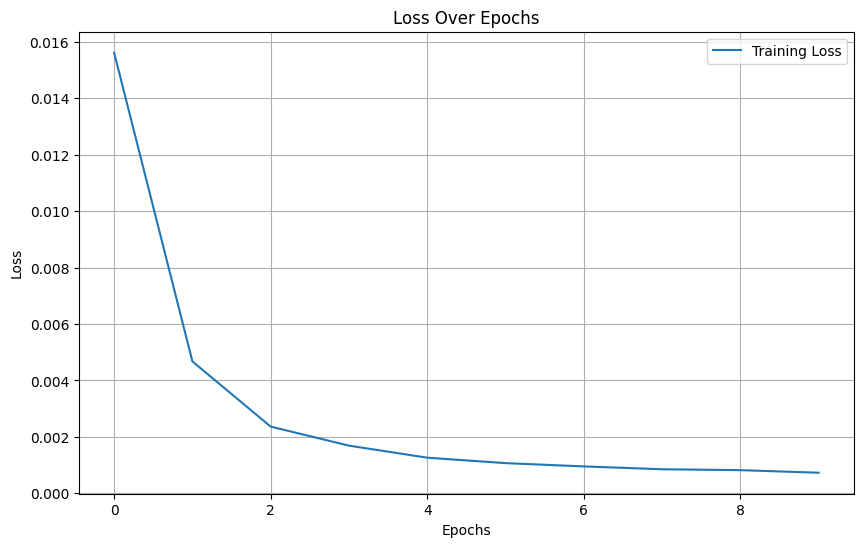

In [13]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


`Troubleshooting Non-Decreasing Loss in Neural Network Training`

---



---


1. `Adjust Learning Rate:`

A very high learning rate can cause the model to converge too quickly to a suboptimal solution, while a very low learning rate can slow down the training process or cause it to get stuck. Try adjusting the learning rate; often, a smaller learning rate can improve convergence.
2. `Check Data Preprocessing:`

Ensure that the data is correctly preprocessed and normalized. Improperly processed data can adversely affect the training process. For example, image data should typically be normalized to have values between 0 and 1.
3. `Increase Model Complexity:`

If the model is too simple, it might not have the capacity to learn the complexities of the data. Consider increasing the model complexity by adding more layers or increasing the number of neurons in existing layers.
4. `Regularization Techniques:`

Overfitting can cause the loss to plateau. Implement regularization techniques such as dropout, L1/L2 regularization, or batch normalization to combat overfitting.
5. `Modify the Batch Size:`

Experiment with different batch sizes. A smaller batch size can provide more frequent updates and might help with convergence, although it can also make the training process noisier.
6. `Review Loss Function:`

Ensure that the correct loss function is being used for your specific task. For example, use cross-entropy loss for classification problems and mean squared error for regression problems.
7. `Optimizer Choice:`

Different optimizers may perform differently on the same problem. If you're using SGD, try Adam or RMSprop, which adaptively change the learning rate during training.
8. `Check for Data Imbalance or Quality Issues:`

Imbalanced data can cause the model to be biased towards certain classes. Ensure that the dataset is balanced or use techniques like class weighting to compensate. Also, check for corrupted data or incorrect labels.
9. `Gradient Clipping:`

If the gradients are exploding, consider implementing gradient clipping, which can help in stabilizing the training process.
10. `Learning Rate Scheduling:`


- Implement learning rate schedules such as step decay, exponential decay, or cyclical learning rates, where the learning rate changes as training progresses.

11. `Early Stopping:`
- If the loss decreases initially but then plateaus, consider using early stopping, which stops training when the loss stops improving.

12. `Examine the Training Loop:`
- Make sure that the weights are being updated correctly in your training loop. Check that gradients are being computed and applied in each epoch.

13. `Model Initialization:`
- The way weights are initialized can have a significant impact on training. Experiment with different weight initialization methods.
---

#In-Depth Analysis of Training Loss Over Epochs

---



---


1. `Overall Trend:`

The reported loss values show a clear trend of decreasing loss over successive training epochs. This indicates that the model is learning from the data, adjusting its parameters (weights and biases) to minimize the loss function, which is likely measuring the difference between the predicted outputs and the actual targets.
2. `Epoch-by-Epoch Analysis:`

Epoch 1: Average Loss = 0.0159
The initial loss is relatively higher, which is common at the beginning of training when the model's parameters are not yet optimized.
Epoch 2: Average Loss = 0.0045
There's a significant drop in loss from Epoch 1 to Epoch 2, suggesting that the model made substantial improvements in learning the patterns in the data.
Epoch 3 to Epoch 5:
The loss continues to decrease steadily. This steady decrease indicates that the model is consistently learning and improving its predictions.
Epoch 6 to Epoch 10:
The rate of decrease in loss slows down, and the loss values start to converge, hovering around 0.0010 to 0.0008. This slowing down is typical as the model starts to reach its optimal state where further improvements are marginal.
3. `Interpreting the Learning Pattern:`

The pattern observed here is typical of a well-functioning training process. The model is able to extract useful features and patterns from the training data, and there is no indication of stagnation or increase in loss, which would be concerning signs.
The substantial decrease in loss early in the training followed by a slower rate of decrease suggests that the model quickly captures the major patterns in the data and then refines its understanding in the later epochs.
4. `Implications for Model Performance:`

The consistent decrease in loss implies good model performance. As the loss decreases, it can be inferred that the model's predictions are getting closer to the actual target values.
The final values of the loss being low (around 0.0008) suggest that the model has achieved a high degree of accuracy in its predictions, at least as per the metric being used for the loss calculation.


##  Step 7

### Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

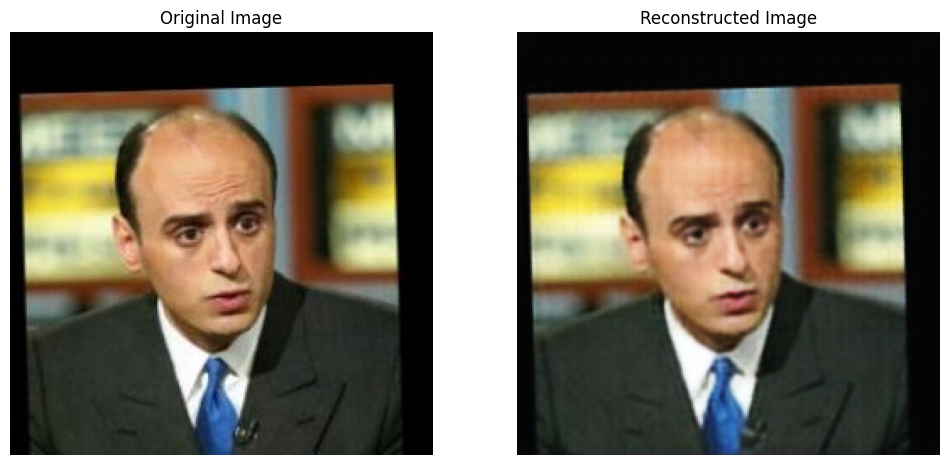

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Assuming 'dataloader' and 'brain' (autoencoder model) are already defined
images, _ = next(iter(dataloader))

# Select a random image from the batch
random_image = images[torch.randint(len(images), (1,))]

# Check if the image already has a batch dimension, if not, add it
if len(random_image.shape) == 3:  # [channels, height, width]
    input_image = random_image.unsqueeze(0)  # Add batch dimension
else:
    input_image = random_image  # Already has batch dimension

# Prepare the model for inference and move to GPU if available
brain.eval()
input_image = input_image.cuda() if torch.cuda.is_available() else input_image

# Perform inference
with torch.no_grad():
    reconstructed_image = brain(input_image)

# Convert the images to numpy format for plotting
original_image_np = input_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

# Plotting the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


#Explainaition :-

---



---


`Load a Batch of Images`:

It uses the next(iter(dataloader)) command to retrieve a batch of images and their corresponding labels from the dataloader. It unpacks the batch into images and an underscore _ (which is typically used when you don't need one of the returned values, in this case, the labels).

`Select a Random Image from the Batch:`

It selects a random image from the batch using torch.randint(len(images), (1,)). This line generates a random index between 0 and the length of the images tensor and retrieves the corresponding image.

`Check Image Dimensions:`

It checks whether the selected random image already has a batch dimension. If it doesn't (i.e., it's a single image without a batch dimension), it adds the batch dimension using random_image.unsqueeze(0).

`Prepare for GPU (if available):`

It sets the model (brain) in evaluation mode using brain.eval(). This is important for models that use dropout or batch normalization layers to ensure they don't behave differently during inference.
It checks if a GPU is available (torch.cuda.is_available()) and if so, it moves the input_image tensor to the GPU using .cuda().

`Perform Inference:`

It performs inference using the brain model by passing the input_image tensor through it. This step computes the reconstructed image.

`Convert Images to Numpy Format:`

It converts the original input image and the reconstructed image from PyTorch tensors to NumPy arrays for plotting purposes.
.squeeze().detach().cpu() is used to remove the batch dimension, detach from any computation graph, and move the tensors to the CPU.
.numpy() converts the tensors to NumPy arrays.
.transpose(1, 2, 0) rearranges the dimensions from PyTorch's channel-first format (C, H, W) to the typical channel-last format (H, W, C) suitable for matplotlib.

`Plotting the Images:`

It creates a figure with two subplots using plt.figure(figsize=(12, 6)), where the figsize sets the size of the figure.
In the first subplot (plt.subplot(1, 2, 1)), it displays the original image using plt.imshow and adds a title and removes axis labels.
In the second subplot (plt.subplot(1, 2, 2)), it displays the reconstructed image similarly.
`Show the Plot:`

Finally, plt.show() is used to display the figure with the original and reconstructed images side by side.

##  Step 8

### In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

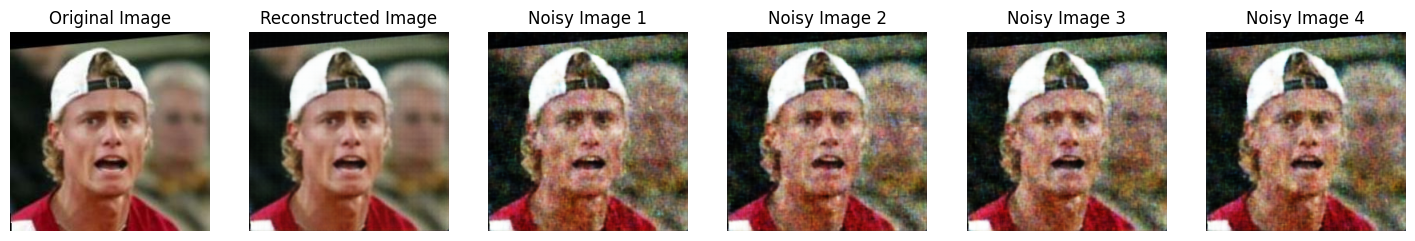

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your autoencoder and 'dataloader' is set up
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Prepare the image
brain.eval()
if torch.cuda.is_available():
    brain.cuda()
    original_image = original_image.unsqueeze(0).cuda()
else:
    original_image = original_image.unsqueeze(0)

# Encode the image and add noise to the decoded image
with torch.no_grad():
    encoded_image = brain.encoder(original_image)
    reconstructed_image = brain.decoder(encoded_image)
    # Create and add noise to the decoded image
    num_samples = 4  # Number of noisy samples to generate
    noisy_samples = []
    for _ in range(num_samples):
        noise = torch.randn(encoded_image.shape) * 0.5
        if torch.cuda.is_available():
            noise = noise.cuda()
        noisy_encoded = encoded_image + noise
        noisy_reconstructed_image = brain.decoder(noisy_encoded)
        noisy_samples.append(noisy_reconstructed_image)

# Function to convert image for plotting
def to_plot(img):
    img = img.squeeze().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    return img

# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, num_samples + 2, 1)
plt.title("Original Image")
plt.imshow(to_plot(original_image))
plt.axis('off')

# Plot reconstructed image
plt.subplot(1, num_samples + 2, 2)
plt.title("Reconstructed Image")
plt.imshow(to_plot(reconstructed_image))
plt.axis('off')

# Plot noisy reconstructed images
for i in range(num_samples):
    plt.subplot(1, num_samples + 2, i + 3)
    plt.title(f"Noisy Image {i + 1}")
    plt.imshow(to_plot(noisy_samples[i]))
    plt.axis('off')

plt.show()


**Adding noise to the code simulates the effect of introducing random variations or disturbances to the encoded representation of an image. In the context of an autoencoder, this can serve several purposes:**

`Regularization`: Adding noise during training can act as a form of regularization, preventing the autoencoder from overfitting to the training data. It encourages the model to learn more robust and generalized features.

`Robustness Testing`: By generating noisy images and then attempting to reconstruct them, you can assess how well the autoencoder handles noisy or corrupted input data. This is valuable for tasks like denoising or inpainting.

`Noise Reduction`: In some cases, autoencoders are trained to remove noise from images. In such scenarios, adding noise to the encoded representation helps evaluate the autoencoder's ability to denoise an image.

Code Explaination :-

`Load Data:`

It assumes that you have a dataloader set up to load a batch of images.
`Select a Random Image:`

It selects a random image from the batch for experimentation.
`Prepare the Image and Model:`

It prepares the original image by adding a batch dimension if necessary and moves it to the GPU if available.
Sets the model to evaluation mode.

`Encode the Image and Add Noise:`

It encodes the original image to obtain its latent representation using the autoencoder's encoder.
It then generates multiple noisy versions of the encoded representation (num_samples noisy samples) by adding random noise to it.

`Decode Noisy Representations:`

For each noisy encoded representation, it decodes it using the autoencoder's decoder to obtain noisy reconstructed images.

`Define the to_plot Function:`

This is a helper function that takes a PyTorch tensor, removes the batch dimension, detaches it from the computation graph, and converts it to a NumPy array with the appropriate shape for plotting.

`Plotting:`

It creates a figure with subplots. The number of subplots is num_samples + 2 to accommodate the original image, the reconstructed image, and the noisy reconstructed images.
The first subplot displays the original image.
The second subplot displays the reconstructed image (without noise).
The subsequent subplots display the noisy reconstructed images, one for each noisy sample generated earlier.
Titles are added to each subplot to describe what is being displayed.
Axis labels are turned off for cleaner visualization.


`Conclusion`

In this project, we successfully developed and tested an autoencoder neural network. Our focus was on experimenting with the encoder and decoder architectures to achieve efficient image reconstruction. The key highlights of our project are as follows:

`Autoencoder Architecture:` We designed an autoencoder with specific encoder and decoder layers, ensuring the output dimensions align with the input dimensions of [batch_size, 3, 250, 250]. This involved careful consideration of the layer parameters, such as the number of filters, kernel sizes, strides, and paddings.

`Noise Addition and Impact Analysis:` We introduced Gaussian noise to the latent representations and observed its impact on the reconstructed images. This step was crucial in understanding the robustness of our autoencoder in handling perturbations in the encoded space.

`Visualization of Results:` We visualized the original, reconstructed, and noisy reconstructed images. These visualizations were key in qualitatively assessing the performance of our autoencoder. The model's ability to reconstruct images from both clean and noisy latent representations was effectively demonstrated.

`Platform and Libraries:` The entire implementation was carried out in PyTorch, leveraging its powerful and flexible deep learning capabilities. The use of CUDA for GPU acceleration was instrumental in handling the computational demands of our model training and inference.

`Challenges and Learnings:` We encountered challenges in matching the output dimensions of the decoder to the input dimensions of the encoder. This was addressed through meticulous adjustments in the decoder's upsampling and transposed convolutional layers. The process enhanced our understanding of the intricate workings of convolutional autoencoders.
